# Essential Libraries

In [149]:
import re
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder, MultiLabelBinarizer, RobustScaler,FunctionTransformer, MinMaxScaler

In [150]:
import warnings
warnings.filterwarnings("ignore")

## Importing Data Set

In [151]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [152]:
print(train.shape)
print(train.info())
print(train.describe().T)
train.head(2)


(100000, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.82262,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.94496,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good


In [153]:
print(test.shape)
print(test.info())
print(train.describe().T)
test.head(2)

(50000, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        50000 non-null  object 
 1   Customer_ID               50000 non-null  object 
 2   Month                     50000 non-null  object 
 3   Name                      44985 non-null  object 
 4   Age                       50000 non-null  object 
 5   SSN                       50000 non-null  object 
 6   Occupation                50000 non-null  object 
 7   Annual_Income             50000 non-null  object 
 8   Monthly_Inhand_Salary     42502 non-null  float64
 9   Num_Bank_Accounts         50000 non-null  int64  
 10  Num_Credit_Card           50000 non-null  int64  
 11  Interest_Rate             50000 non-null  int64  
 12  Num_of_Loan               50000 non-null  object 
 13  Type_of_Loan              44296 non-null  object 

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196


## Identify and Remove Null Values

### Train

In [154]:
train.isna().sum().sort_values(ascending=False).head(10)

Monthly_Inhand_Salary      15002
Type_of_Loan               11408
Name                        9985
Credit_History_Age          9030
Num_of_Delayed_Payment      7002
Amount_invested_monthly     4479
Num_Credit_Inquiries        1965
Monthly_Balance             1200
Month                          0
Age                            0
dtype: int64

In [155]:
# This column has no usage in Credit prediction
train = train.drop('Name',axis=1)
train = train.drop('ID',axis=1)
train = train.drop('SSN',axis=1)
train = train.drop('Age',axis=1)
train = train.drop('Month',axis=1)
train = train.drop('Occupation',axis=1)
train = train.drop('Amount_invested_monthly',axis=1)

# Fill with Median Values
cols = ['Monthly_Inhand_Salary', 'Num_of_Delayed_Payment',
        'Num_Credit_Inquiries', 'Monthly_Balance']

# Convert to numeric (force errors to become NaN)
train[cols] = train[cols].apply(pd.to_numeric, errors='coerce')

train['Monthly_Inhand_Salary'] = train['Monthly_Inhand_Salary'].fillna(train['Monthly_Inhand_Salary'].median())
train['Num_of_Delayed_Payment'] = train['Num_of_Delayed_Payment'].fillna(train['Num_of_Delayed_Payment'].median())
train['Num_Credit_Inquiries'] = train['Num_Credit_Inquiries'].fillna(train['Num_Credit_Inquiries'].median())
train['Monthly_Balance'] = train['Monthly_Balance'].fillna(train['Monthly_Balance'].median())

# Replace value with Unknown value to Preserves category info
train['Type_of_Loan'] = train['Type_of_Loan'].fillna('Unknown')

# Use Regex Code to convert values
train['Credit_History_Age'] = train['Credit_History_Age'].str.extract(r'(\d+)').astype(float)
train['Credit_History_Age'].fillna(train['Credit_History_Age'].median(), inplace=True)
train['Credit_Mix'] = train['Credit_Mix'].str.match(r'^(Standard|Good|Bad)$', na=False)

print(train.isna().sum().sort_values(ascending=False).head(10))

Customer_ID               0
Annual_Income             0
Monthly_Inhand_Salary     0
Num_Bank_Accounts         0
Num_Credit_Card           0
Interest_Rate             0
Num_of_Loan               0
Type_of_Loan              0
Delay_from_due_date       0
Num_of_Delayed_Payment    0
dtype: int64


### Test

In [156]:
test.isna().sum().sort_values(ascending=False).head(10)

Monthly_Inhand_Salary      7498
Type_of_Loan               5704
Name                       5015
Credit_History_Age         4470
Num_of_Delayed_Payment     3498
Amount_invested_monthly    2271
Num_Credit_Inquiries       1035
Monthly_Balance             562
Customer_ID                   0
Month                         0
dtype: int64

In [157]:
# This column has no usage in Credit prediction
test = test.drop('Name', axis=1)
test = test.drop('ID', axis=1)
test = test.drop('SSN', axis=1)
test = test.drop('Age', axis=1)
test = test.drop('Month', axis=1)
test = test.drop('Occupation', axis=1)
test = test.drop('Amount_invested_monthly', axis=1)

# Fill with Median Values
cols = ['Monthly_Inhand_Salary', 'Num_of_Delayed_Payment',
        'Num_Credit_Inquiries', 'Monthly_Balance']

# Convert to numeric (force errors to become NaN)
test[cols] = test[cols].apply(pd.to_numeric, errors='coerce')

test['Monthly_Inhand_Salary'] = test['Monthly_Inhand_Salary'].fillna(test['Monthly_Inhand_Salary'].median())
test['Num_of_Delayed_Payment'] = test['Num_of_Delayed_Payment'].fillna(test['Num_of_Delayed_Payment'].median())
test['Num_Credit_Inquiries'] = test['Num_Credit_Inquiries'].fillna(test['Num_Credit_Inquiries'].median())
test['Monthly_Balance'] = test['Monthly_Balance'].fillna(test['Monthly_Balance'].median())

# Replace value with Unknown value to preserve category info
test['Type_of_Loan'] = test['Type_of_Loan'].fillna('Unknown')

# Use Regex Code to convert values
test['Credit_History_Age'] = test['Credit_History_Age'].str.extract(r'(\d+)').astype(float)
test['Credit_History_Age'].fillna(test['Credit_History_Age'].median(), inplace=True)

test['Credit_Mix'] = test['Credit_Mix'].str.match(r'^(Standard|Good|Bad)$', na=False)

print(test.isna().sum().sort_values(ascending=False).head(10))

Customer_ID               0
Annual_Income             0
Monthly_Inhand_Salary     0
Num_Bank_Accounts         0
Num_Credit_Card           0
Interest_Rate             0
Num_of_Loan               0
Type_of_Loan              0
Delay_from_due_date       0
Num_of_Delayed_Payment    0
dtype: int64


# Visualization(EDA)

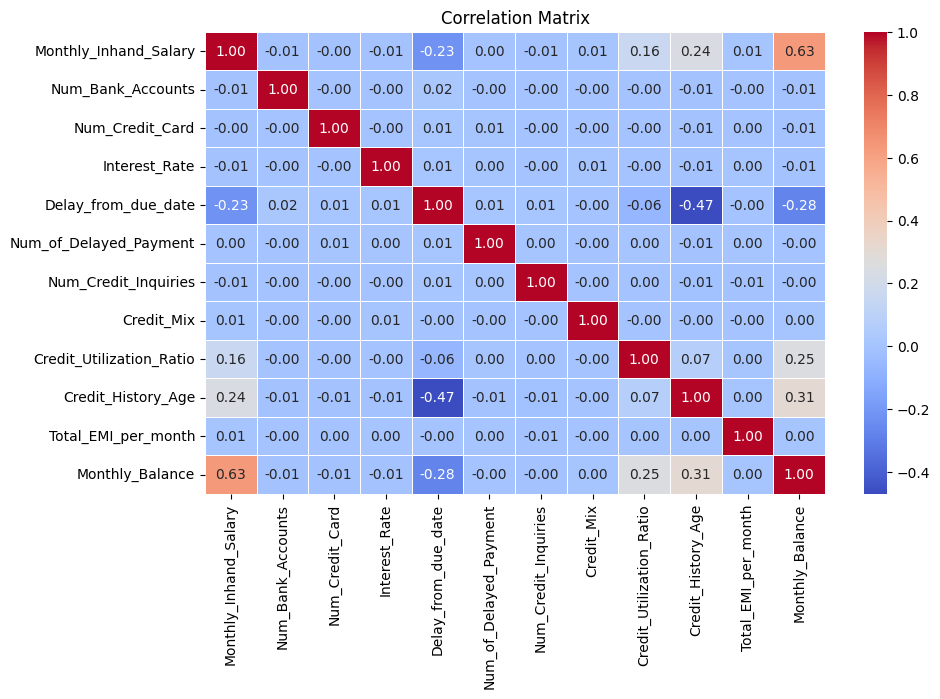

In [158]:
corr = train.corr(numeric_only=True)

plt.figure(figsize=(10, 6))

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

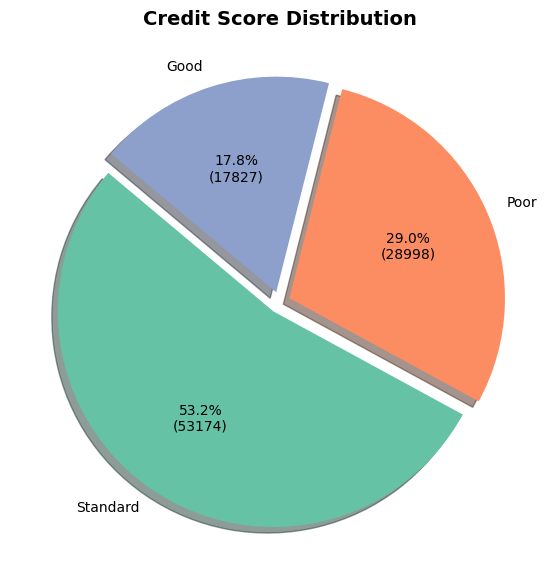

In [159]:
Credit_Score = train['Credit_Score'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(
    Credit_Score,
    labels=Credit_Score.index,
    autopct=lambda p: f'{p:.1f}%\n({int(p*sum(Credit_Score)/100)})',
    startangle=140,
    shadow=True,
    explode=[0.05]*len(Credit_Score),
    colors=plt.cm.Set2.colors
)

plt.title("Credit Score Distribution", fontsize=14, weight='bold')
plt.show()

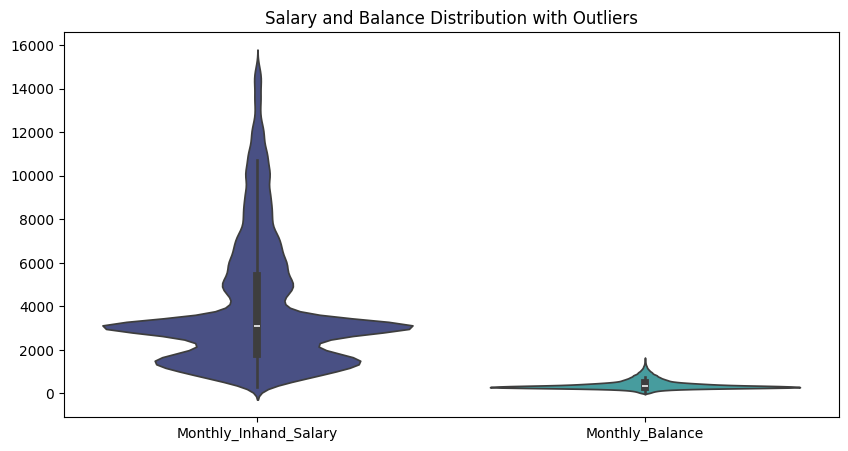

In [160]:
plt.figure(figsize=(10,5))
sns.violinplot(data=train[['Monthly_Inhand_Salary','Monthly_Balance']],palette='mako')
plt.title("Salary and Balance Distribution with Outliers")
plt.show()

Text(0.5, 1.0, 'Ratio of Delay from Due Date ')

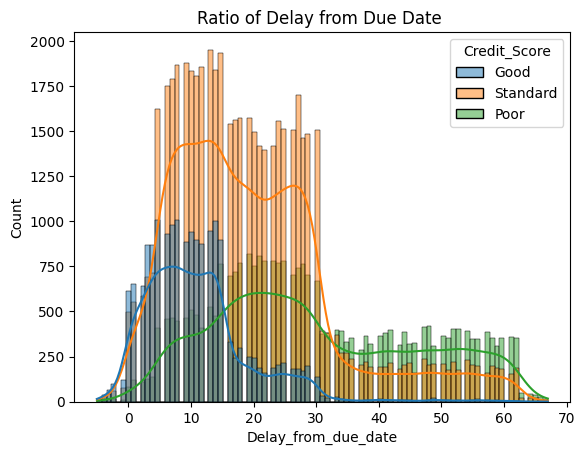

In [161]:
sns.histplot(train,x='Delay_from_due_date',kde=True,hue='Credit_Score')
plt.title("Ratio of Delay from Due Date ")

# Aggregation

### Train

In [162]:
# Group by User_ID and aggregate
num_train = train.select_dtypes(include='number').groupby(train['Customer_ID']).mean()
cat_train = train.select_dtypes(exclude='number').groupby(train['Customer_ID']).agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)

# Combine numeric + categorical
train = pd.concat([num_train, cat_train], axis=1)

# Drop unique identifiers that don't help prediction
train.drop('Customer_ID',axis=1, inplace=True, errors='ignore')

print("Aggregation complete!")
print("New shape:", train.shape)

Aggregation complete!
New shape: (12500, 20)


### Test

In [163]:
# Group by User_ID and aggregate
num_test = test.select_dtypes(include='number').groupby(test['Customer_ID']).mean()
cat_test = test.select_dtypes(exclude='number').groupby(test['Customer_ID']).agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)

# Combine numeric + categorical
test = pd.concat([num_test, cat_test], axis=1)

# Drop unique identifiers that don't help prediction
test.drop('Customer_ID',axis=1, inplace=True, errors='ignore')

print("Aggregation complete!")
print("New shape:", test.shape)

Aggregation complete!
New shape: (12500, 19)


## Encoding & Scalling

### Train

In [164]:
def clean_and_preprocess(df):

    df = df.copy()
    le = LabelEncoder()
    
    # 1. Clean and Label Encode Categorical/Binary Columns
    cat_cols = ['Credit_Mix', 'Payment_of_Min_Amount', 'Credit_Score']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.replace('_', '')
            df[col] = le.fit_transform(df[col])

    # 2. Process Multi-label 'Type_of_Loan'
    if 'Type_of_Loan' in df.columns:
        df['Type_of_Loan'] = df['Type_of_Loan'].str.replace('and ', '', regex=False)
        df['Type_of_Loan'] = df['Type_of_Loan'].apply(
            lambda x: [i.strip() for i in str(x).split(',')] if x not in ['Unknown', None, 'nan'] else []
        )
        mlb = MultiLabelBinarizer()
        loan_encoded = mlb.fit_transform(df['Type_of_Loan'])
        loan_cols = pd.DataFrame(loan_encoded, columns=mlb.classes_, index=df.index)
        df = pd.concat([df, loan_cols], axis=1).drop('Type_of_Loan', axis=1)

    # 3. One-Hot Encode 'Payment_Behaviour'
    if 'Payment_Behaviour' in df.columns:
        df = pd.get_dummies(df, columns=['Payment_Behaviour'], prefix='Pay_Behav', dtype=int)
        # Remove known noise column if it exists
        if 'Pay_Behav_!@9#%8' in df.columns:
            df.drop(columns=['Pay_Behav_!@9#%8'], inplace=True)

    # 4. Clean and Scale Numerical Columns
    num_features = [
        'Monthly_Inhand_Salary', 'Annual_Income', 'Outstanding_Debt', 
        'Total_EMI_per_month', 'Monthly_Balance', 'Interest_Rate'
    ]
    
    for col in num_features:
        if col in df.columns:
            # Remove underscores and force to numeric
            df[col] = pd.to_numeric(df[col].astype(str).str.replace('_', ''), errors='coerce')
            # Handle potential NaNs by filling with median
            df[col] = df[col].fillna(df[col].median())

    # Scaling with RobustScaler (ideal for handling outliers in credit data)
    scaler = RobustScaler()
    available_nums = [c for c in num_features if c in df.columns]
    if available_nums:
        df[available_nums] = scaler.fit_transform(df[available_nums])


    return df

train_enc = clean_and_preprocess(train)

print(train_enc.shape)
train.head(5).T

(12500, 33)


Customer_ID,CUS_0x1000,CUS_0x1009,CUS_0x100b,CUS_0x1011,CUS_0x1013
Monthly_Inhand_Salary,2754.609583,4250.39,8742.777813,4944.481563,6136.66375
Num_Bank_Accounts,6.0,6.0,1.0,3.0,3.0
Num_Credit_Card,5.0,5.0,4.0,3.0,3.0
Interest_Rate,27.0,17.0,1.0,17.0,6.0
Delay_from_due_date,62.25,7.25,13.5,27.25,12.5
Num_of_Delayed_Payment,25.0,234.25,7.375,14.0,9.125
Num_Credit_Inquiries,10.875,3.0,285.5,251.75,3.0
Credit_Utilization_Ratio,33.477546,29.839984,34.841449,27.655897,31.93394
Credit_History_Age,10.0,28.625,15.375,15.0,17.125
Total_EMI_per_month,42.94109,108.366467,0.0,123.434939,6266.765823


### Test

In [165]:
def clean_and_preprocess(df):

    df = df.copy()
    le = LabelEncoder()
    
    # 1. Clean and Label Encode Categorical/Binary Columns
    cat_cols = ['Credit_Mix', 'Payment_of_Min_Amount']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().str.replace('_', '')
            df[col] = le.fit_transform(df[col])

    # 2. Process Multi-label 'Type_of_Loan'
    if 'Type_of_Loan' in df.columns:
        df['Type_of_Loan'] = df['Type_of_Loan'].str.replace('and ', '', regex=False)
        df['Type_of_Loan'] = df['Type_of_Loan'].apply(
            lambda x: [i.strip() for i in str(x).split(',')] if x not in ['Unknown', None, 'nan'] else []
        )
        mlb = MultiLabelBinarizer()
        loan_encoded = mlb.fit_transform(df['Type_of_Loan'])
        loan_cols = pd.DataFrame(loan_encoded, columns=mlb.classes_, index=df.index)
        df = pd.concat([df, loan_cols], axis=1).drop('Type_of_Loan', axis=1)

    # 3. One-Hot Encode 'Payment_Behaviour'
    if 'Payment_Behaviour' in df.columns:
        df = pd.get_dummies(df, columns=['Payment_Behaviour'], prefix='Pay_Behav', dtype=int)
        # Remove known noise column if it exists
        if 'Pay_Behav_!@9#%8' in df.columns:
            df.drop(columns=['Pay_Behav_!@9#%8'], inplace=True)

    # 4. Clean and Scale Numerical Columns
    num_features = [
        'Monthly_Inhand_Salary', 'Annual_Income', 'Outstanding_Debt', 
        'Total_EMI_per_month', 'Monthly_Balance', 'Interest_Rate'
    ]
    
    for col in num_features:
        if col in df.columns:
            # Remove underscores and force to numeric
            df[col] = pd.to_numeric(df[col].astype(str).str.replace('_', ''), errors='coerce')
            # Handle potential NaNs by filling with median
            df[col] = df[col].fillna(df[col].median())

    # Scaling with RobustScaler (ideal for handling outliers in credit data)
    scaler = RobustScaler()
    available_nums = [c for c in num_features if c in df.columns]
    if available_nums:
        df[available_nums] = scaler.fit_transform(df[available_nums])


    return df

test_enc = clean_and_preprocess(test)

print(test_enc.shape)
test.head(5).T

(12500, 32)


Customer_ID,CUS_0x1000,CUS_0x1009,CUS_0x100b,CUS_0x1011,CUS_0x1013
Monthly_Inhand_Salary,2706.161667,4250.39,7933.913125,4678.230625,7962.415
Num_Bank_Accounts,6.0,6.0,1.0,3.0,3.0
Num_Credit_Card,5.0,5.0,4.0,3.0,3.0
Interest_Rate,27.0,17.0,1.0,17.0,6.0
Delay_from_due_date,62.75,7.0,12.75,27.75,12.0
Num_of_Delayed_Payment,25.0,20.0,7.25,14.25,9.25
Num_Credit_Inquiries,11.0,4.0,4.0,10.75,5.25
Credit_Utilization_Ratio,29.775428,34.225544,36.890874,31.77332,34.645481
Credit_History_Age,10.5,31.0,15.75,15.75,17.75
Total_EMI_per_month,42.94109,1455.52485,0.0,123.434939,228.018084


# Feature Engineering

In [166]:
def feature_engineering(df):
    # Create a copy to avoid SettingWithCopy warnings
    df = df.copy()
    epsilon = 1e-6
    
    # --- STEP 1: CLEANING NUMERIC COLUMNS ---
    source_cols = [
        'Outstanding_Debt', 'Annual_Income', 'Num_of_Loan', 
        'Interest_Rate', 'Monthly_Inhand_Salary', 'Num_of_Delayed_Payment', 
        'Delay_from_due_date', 'Num_Credit_Inquiries', 
        'Total_EMI_per_month', 'Monthly_Balance'
    ]
    
    for col in source_cols:
        if col in df.columns:
            # Convert to string, remove non-numeric chars (keeping decimal and signs)
            df[col] = df[col].astype(str).str.replace(r'[^0-9.-]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')
            # Fill NaNs with median for stability
            col_median = df[col].median()
            df[col] = df[col].fillna(col_median if pd.notna(col_median) else 0)

    # --- STEP 2: LOGICAL OUTLIER CAPPING ---
    df['Annual_Income'] = df['Annual_Income'].clip(lower=0, upper=1000000) 
    df['Num_of_Loan'] = df['Num_of_Loan'].clip(lower=0, upper=20)
    df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].clip(lower=0, upper=100)
    df['Outstanding_Debt'] = df['Outstanding_Debt'].clip(lower=0, upper=30000)

    # --- STEP 3: TEMPORAL FEATURE CONVERSION ---
    if 'Credit_History_Age' in df.columns:
        # Check if data is already numeric (like in your check.csv)
        if pd.api.types.is_numeric_dtype(df['Credit_History_Age']):
            df['Credit_History_Age_Months'] = df['Credit_History_Age'] * 12
        else:
            # If it's the "XX Years and YY Months" string format
            age_series = df['Credit_History_Age'].astype(str)
            years = age_series.str.extract(r'(\d+)\s*Years').astype(float).fillna(0)
            months = age_series.str.extract(r'(\d+)\s*Months').astype(float).fillna(0)
            df['Credit_History_Age_Months'] = (years * 12) + months
        
        df = df.drop(columns=['Credit_History_Age'], errors='ignore')

    # --- STEP 4: RATIO CALCULATIONS ---
    # Using +1 or epsilon to avoid division by zero
    df['Debt_to_Income'] = df['Outstanding_Debt'] / (df['Annual_Income'] + epsilon)
    df['Loan_to_Income'] = df['Num_of_Loan'] / (df['Annual_Income'] + epsilon)
    df['Interest_Burden'] = (df['Interest_Rate'] * df['Num_of_Loan']) / (df['Monthly_Inhand_Salary'] + epsilon)

    df['Payment_Delay_Ratio'] = df['Num_of_Delayed_Payment'] / (df['Num_of_Loan'] + epsilon)
    df['Delay_Severity'] = df['Delay_from_due_date'] / (df['Num_of_Delayed_Payment'] + epsilon)
    df['Credit_Inquiry_Pressure'] = df['Num_Credit_Inquiries'] / (df['Num_of_Loan'] + epsilon)

    df['Disposable_Income'] = df['Monthly_Inhand_Salary'] - df['Total_EMI_per_month']
    df['Effective_Monthly_Balance'] = df['Monthly_Balance'] - df['Outstanding_Debt']

    df['Credit_Stress_Index'] = df['Debt_to_Income'] * df['Interest_Burden']
    # Refined Stability Score: Weighted Monthly Liquidity vs Debt
    df['Financial_Stability_Score'] = df['Disposable_Income'] / (1 + df['Debt_to_Income'])

    # --- STEP 5: FINAL CLEANUP & RATIO CAPPING ---
    engineered_features = [
        'Debt_to_Income', 'Loan_to_Income', 'Interest_Burden',
        'Payment_Delay_Ratio', 'Delay_Severity', 'Credit_Inquiry_Pressure', 
        'Disposable_Income', 'Effective_Monthly_Balance',
        'Credit_Stress_Index', 'Financial_Stability_Score'
    ]
    
    # Replace any infinity values created by division
    df[engineered_features] = df[engineered_features].replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Cap extreme ratios so they don't dominate the model
    df['Debt_to_Income'] = df['Debt_to_Income'].clip(0, 5)
    df['Loan_to_Income'] = df['Loan_to_Income'].clip(0, 1) 
    df['Interest_Burden'] = df['Interest_Burden'].clip(0, 100)
    
    # Drop non-predictive identifiers
    id_cols = ['ID', 'Customer_ID', 'Name', 'SSN']
    df = df.drop(columns=[c for c in id_cols if c in df.columns], errors='ignore')
    
    return df

train_enc = feature_engineering(train_enc)
test_enc = feature_engineering(test_enc)

print("Train shape:",train_enc.shape)
print("Test shape:",test_enc.shape)

Train shape: (12500, 43)
Test shape: (12500, 42)


# Model Building

In [167]:
X = train_enc.drop('Credit_Score', axis=1)
Y = train_enc['Credit_Score']

X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size=0.2, random_state=42)
X_train['Changed_Credit_Limit'] = pd.to_numeric(X_train['Changed_Credit_Limit'], errors='coerce')
X_test['Changed_Credit_Limit'] = pd.to_numeric(X_test['Changed_Credit_Limit'], errors='coerce')


## Random Forest Classifier

In [168]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,         
    min_samples_split=10,     
    min_samples_leaf=5,      
    max_features=0.5,      
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1,
    oob_score=True
    )

RandomForestClassifier
# Train
rf.fit(X_train, Y_train)

# Train Score
RF_pred_train = rf.predict(X_train)
print("Train Accuracy:", accuracy_score(Y_train, RF_pred_train))
print(classification_report(Y_train, RF_pred_train))
# Confusion Matrix
cm = confusion_matrix(Y_train, RF_pred_train)
plt.figure(figsize=(6, 4))
print("Confustion Matrix:",cm)

# Test Score
RF_pred_test = rf.predict(X_test)
print("Test Accuracy:", accuracy_score(Y_test, RF_pred_test))
print(classification_report(Y_test, RF_pred_test))
# Confusion Matrix
cm = confusion_matrix(Y_test, RF_pred_test)
print("Confustion Matrix:",cm)

Train Accuracy: 0.8788
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1988
           1       0.92      0.87      0.89      3340
           2       0.92      0.87      0.89      4672

    accuracy                           0.88     10000
   macro avg       0.86      0.89      0.87     10000
weighted avg       0.89      0.88      0.88     10000

Confustion Matrix: [[1818   26  144]
 [ 232 2914  194]
 [ 379  237 4056]]
Test Accuracy: 0.7308
              precision    recall  f1-score   support

           0       0.59      0.79      0.68       518
           1       0.78      0.77      0.78       822
           2       0.79      0.68      0.73      1160

    accuracy                           0.73      2500
   macro avg       0.72      0.74      0.73      2500
weighted avg       0.74      0.73      0.73      2500

Confustion Matrix: [[407  13  98]
 [ 71 634 117]
 [207 167 786]]


<Figure size 600x400 with 0 Axes>

# XGBoostClassifier

In [169]:
xgb_model = XGBClassifier(
    n_estimators=400,      
    learning_rate=0.05,   
    max_depth=6,           
    subsample=0.8,         
    colsample_bytree=0.8,
    min_child_weight=5, 
    reg_lambda=10,        
    reg_alpha=2,  
    gamma=0.2,        
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42
    )
# Applying Cross validation
cv_scores = cross_val_score(xgb_model, X_train, Y_train, cv=5, scoring='accuracy')
print(f"Accuracy per fold: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

# Model Training
xgb_model.fit(X_train,Y_train)

# Train Score  
XG_pred_train = xgb_model.predict(X_train)
print("Train Accuracy:", accuracy_score(Y_train, XG_pred_train))
print(classification_report(Y_train, XG_pred_train))
# Confusion Matrix
cm = confusion_matrix(Y_train, XG_pred_train)
print("Confustion Matrix:",cm)

# Test Score
XG_pred_test = xgb_model.predict(X_test)
print("Test Accuracy:", accuracy_score(Y_test, XG_pred_test))
print(classification_report(Y_test, XG_pred_test))
# Confusion Matrix
cm = confusion_matrix(Y_test, XG_pred_test)
print("Confustion Matrix:",cm)

Accuracy per fold: [0.7045 0.72   0.7085 0.716  0.7115]
Mean Accuracy: 0.7121
Standard Deviation: 0.0055
Train Accuracy: 0.8899
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1988
           1       0.92      0.87      0.90      3340
           2       0.89      0.92      0.90      4672

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.89      0.89     10000

Confustion Matrix: [[1694   30  264]
 [ 132 2917  291]
 [ 159  225 4288]]
Test Accuracy: 0.7288
              precision    recall  f1-score   support

           0       0.62      0.65      0.64       518
           1       0.80      0.75      0.77       822
           2       0.73      0.75      0.74      1160

    accuracy                           0.73      2500
   macro avg       0.72      0.72      0.72      2500
weighted avg       0.73      0.73      0.73      2500

Confustion Mat

In [170]:
import pandas as pd

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance

,Feature,Importance
14,Outstanding_Debt,0.159379
15,Payment_of_Min_Amount,0.143375
4,Delay_from_due_date,0.074932
3,Interest_Rate,0.063662
32,Debt_to_Income,0.060788
12,Changed_Credit_Limit,0.053780
39,Effective_Monthly_Balance,0.043385
5,Num_of_Delayed_Payment,0.040201
2,Num_Credit_Card,0.031686
31,Credit_History_Age_Months,0.030137


# Gradient Boost Classifier

In [171]:
gb_model = GradientBoostingClassifier(
        n_estimators=200,    
        learning_rate=0.05,  
        max_depth=5,           
        subsample=0.8,         
        max_features='sqrt',   
        random_state=42
    )

# 2. Applying Cross validation
cv_scores = cross_val_score(gb_model, X_train, Y_train, cv=5, scoring='accuracy')
print(f"Accuracy per fold: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")

# 3. Final Training
gb_model.fit(X_train, Y_train)

# Train Score
Gb_pred_train = gb_model.predict(X_train)
print("Train Accuracy:", accuracy_score(Y_train, Gb_pred_train))
print(classification_report(Y_train, Gb_pred_train))
# Confusion Matrix
cm = confusion_matrix(Y_train, Gb_pred_train)
print("Confustion Matrix:",cm)

# Train Score
Gb_pred_test = gb_model.predict(X_test)
print("Test Accuracy:", accuracy_score(Y_test, Gb_pred_test))
print(classification_report(Y_test, Gb_pred_test))
# Confusion Matrix
cm = confusion_matrix(Y_test, Gb_pred_test)
print("Confustion Matrix:",cm)

Accuracy per fold: [0.7095 0.716  0.703  0.7155 0.709 ]
Mean Accuracy: 0.7106
Train Accuracy: 0.825
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1988
           1       0.88      0.81      0.85      3340
           2       0.82      0.86      0.84      4672

    accuracy                           0.82     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.83      0.82      0.83     10000

Confustion Matrix: [[1502   23  463]
 [ 203 2717  420]
 [ 306  335 4031]]
Test Accuracy: 0.7236
              precision    recall  f1-score   support

           0       0.63      0.62      0.63       518
           1       0.79      0.75      0.77       822
           2       0.72      0.75      0.73      1160

    accuracy                           0.72      2500
   macro avg       0.71      0.71      0.71      2500
weighted avg       0.72      0.72      0.72      2500

Confustion Matrix: [[323  11 184]
 [ 50 62

# Final Prediction for the Test data

In [172]:
x = test_enc
x = x.replace('_', np.nan)


In [173]:
rf.fit(X,Y)

y = rf.predict(x)

# Train Score
pred_train = rf.predict(X)
print("Train Accuracy:", accuracy_score(Y, pred_train))
print(classification_report(Y, pred_train))
# Confusion Matrix
cm = confusion_matrix(Y, pred_train)
plt.figure(figsize=(6, 4))
print("Confustion Matrix:",cm)

# Test Score
pred_test = rf.predict(x)
print("Test Accuracy:", accuracy_score(y,pred_test))
print(classification_report(y, pred_test))
# Confusion Matrix
cm = confusion_matrix(y, pred_test)
print("Confustion Matrix:",cm)

Train Accuracy: 0.8776
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      2506
           1       0.92      0.87      0.89      4162
           2       0.92      0.87      0.89      5832

    accuracy                           0.88     12500
   macro avg       0.86      0.88      0.87     12500
weighted avg       0.89      0.88      0.88     12500

Confustion Matrix: [[2292   27  187]
 [ 293 3629  240]
 [ 490  293 5049]]
Test Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3417
           1       1.00      1.00      1.00      3980
           2       1.00      1.00      1.00      5103

    accuracy                           1.00     12500
   macro avg       1.00      1.00      1.00     12500
weighted avg       1.00      1.00      1.00     12500

Confustion Matrix: [[3417    0    0]
 [   0 3980    0]
 [   0    0 5103]]


<Figure size 600x400 with 0 Axes>

# Model Saving

In [175]:
import pickle

# Saving base model
with open ('random_forest.pkl','wb') as file:
    pickle.dump(rf,file)

# Saving Important features
feature_importance['Importance'] = feature_importance['Importance'].round(4)
feature_importance = feature_importance.head(40)
feature_importance.to_json('final_feature.json')

# Saving test data with prediction
test['Pred_y'] = y

test.to_csv("Predicted_Test.csv")

In [176]:
X_train.head()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month,Monthly_Balance,...,Debt_to_Income,Loan_to_Income,Interest_Burden,Payment_Delay_Ratio,Delay_Severity,Credit_Inquiry_Pressure,Disposable_Income,Effective_Monthly_Balance,Credit_Stress_Index,Financial_Stability_Score
Customer_ID,,,,,,,,,,,,,,,,,,,,,
CUS_0x5607,1.693145,2.0,6.0,-0.473684,26.625,5.625,1.000,31.888260,1.543870,1.781916,...,0.000000,1.0,0.000000,1.874999,4.733332,0.333333,0.149276,1.781916,-0.000000e+00,1.492757e-01
CUS_0x1698,-0.606424,6.0,5.0,0.947368,39.500,15.875,9.375,29.481204,-0.232049,-0.304929,...,5.000000,1.0,0.000000,3.968749,2.488189,2.343749,-0.374375,-1.180271,-5.469921e+06,-4.276898e-07
CUS_0x51e6,0.550075,3.0,6.0,0.105263,9.500,13.875,8.000,33.549136,0.032389,0.862050,...,1.441605,1.0,0.574084,4.624998,0.684685,2.666666,0.517686,-0.073680,8.276017e-01,2.120270e-01
CUS_0x8991,1.302865,4.0,4.0,-0.631579,11.375,12.000,2.000,34.845920,0.401799,2.776479,...,0.000000,1.0,0.000000,3.999999,0.947917,0.666666,0.901066,2.776479,-0.000000e+00,9.010659e-01
CUS_0x3f8b,-0.417430,8.0,5.0,0.210526,9.375,18.750,11.750,32.519782,-0.181385,-0.284569,...,5.000000,1.0,0.000000,4.687499,0.500000,2.937499,-0.236044,-1.324228,-2.097369e+06,-2.270401e-07


In [181]:
X_train.columns

Index(['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Num_Credit_Inquiries', 'Credit_Utilization_Ratio',
       'Total_EMI_per_month', 'Monthly_Balance', 'Annual_Income',
       'Num_of_Loan', 'Changed_Credit_Limit', 'Credit_Mix', 'Outstanding_Debt',
       'Payment_of_Min_Amount', 'Auto Loan', 'Credit-Builder Loan',
       'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan',
       'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan',
       'Pay_Behav_High_spent_Large_value_payments',
       'Pay_Behav_High_spent_Medium_value_payments',
       'Pay_Behav_High_spent_Small_value_payments',
       'Pay_Behav_Low_spent_Large_value_payments',
       'Pay_Behav_Low_spent_Medium_value_payments',
       'Pay_Behav_Low_spent_Small_value_payments', 'Credit_History_Age_Months',
       'Debt_to_Income', 'Loan_to_Income', 'Interest_Burden',
       'Payment_Delay_Ratio', 'Delay_

# Streamlit APP Building

In [ ]:
import streamlit as st

def user_input()
    Monthly_Inhand_Salary = st.sidebar.number_input('Monthly Inhand Salary',min=0,max=1000000,step=10,value=150)
    Num_Bank_Accounts = st.sidebar.number_input('Numbers of Bank Account',min=0,max=20,step=1,value=2)
    Num_Credit_Card = st.sidebar.number_input('Numbers of Credit Card',min=0,max=20,step=1,value=2)
    Interest_Rate = st.sidebar.number_input('Interest Rate',min=0,max=50,step=1,value=0)
    Delay_from_due_date = st.sidebar.number_input('Delay From Due Date',min=0,max=50,step=1,value=0)
    Num_of_Delayed_Payment = st.sidebar.number_input('Number of Delay Payment',min=0,max=50,step=1,value=0)
    Num_Credit_Inquiries = st.sidebar.number_input('Number of Credit Enquiries',min=0,max=50,step=1,value=0)
    Credit_Utilization_Ratio = st.sidebar.number_input('Credit Utilization Ratio',min=0,max=100,step=1,value=0)
    Total_EMI_per_month = st.sidebar.number_input('Total EMI per Month',min=0,max=1000000,step=10)
    Monthly_Balance = st.sidebar.number_input('Monthly Balance',min=0,max=1000000,step=10)
    Annual_Income = st.sidebar.number_input('Annual Income',min=0,max=1000000,step=10,value=1000)
    Num_of_Loan = st.sidebar.number_input('Numbers of Loan',min=0,max=20,step=1,value=2)
    Changed_Credit_Limit = st.sidebar.number_input('Changed Credit Limit',min=0,max=100,step=1,value=0)
    Credit_Mix = st.sidebar.selectbox('Credit Mix', ['Good', 'Standard', 'Bad'])
    Outstanding_Debt = st.sidebar.number_input('Changed Credit Limit',min=0,max=10000,step=10,value=0)
    Payment_of_Min_Amount = st.sidebar.selectbox('Payment of Minumum AMount', ['Yes', 'No'])
    Type_of_Loan = st.sidebar.multiselect('Types of Loan',['Auto Loan', 'Credit-Builder Loan',
       'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan',
       'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan'])
    Payment_Behaviour = st.sidebar.selectbox('Payment Behaviour',[
        'Pay_Behav_High_spent_Large_value_payments',
        'Pay_Behav_High_spent_Medium_value_payments',
        'Pay_Behav_High_spent_Small_value_payments',
        'Pay_Behav_Low_spent_Large_value_payments',
        'Pay_Behav_Low_spent_Medium_value_payments',
        'Pay_Behav_Low_spent_Small_value_payments'])
    Credit_History_Age_Months = st.select_slider('Credit History Age(Month)',min=0,max=1000,step=1)

    loan_types = ['Auto Loan', 'Credit-Builder Loan',
       'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan',
       'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan']

    user_data = {
        'Monthly_Inhand_Salary': Monthly_Inhand_Salary,
        'Num_Bank_Accounts': Num_Bank_Accounts,
        'Num_Credit_Card': Num_Credit_Card,
        'Interest_Rate': Interest_Rate,
        'Delay_from_due_date': Delay_from_due_date,
        'Num_of_Delayed_Payment': Num_of_Delayed_Payment,
        'Num_Credit_Inquiries': Num_Credit_Inquiries,
        'Credit_Utilization_Ratio': Credit_Utilization_Ratio,
        'Total_EMI_per_month': Total_EMI_per_month,
        'Monthly_Balance': Monthly_Balance,
        'Annual_Income': Annual_Income,
        'Num_of_Loan': Num_of_Loan,
        'Changed_Credit_Limit': Changed_Credit_Limit,
        f'Credit_Mix_{Credit_Mix}': 1,
        'Outstanding_Debt': Outstanding_Debt,
        f'Payment_of_Min_Amount_{Payment_of_Min_Amount}': 1,
        f'Type_of_Loan_{Type_of_Loan}': 
        user_data.update({f'Type_of_Loan_{loan}': 1 if loan in Type_of_Loan else 0 for loan in loan_types})

        # Convert to DataFrame and align with training columns
        input_df = pd.DataFrame([user_data]).reindex(columns=X_train.columns, fill_value=0)
    }

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1103223985.py, line 55)